<a href="https://colab.research.google.com/github/sidgtx/projectx/blob/main/neuralnet/neuralpde/pde_models_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fisher-KPP

Compiling model...
Building feed-forward neural network...
'build' took 0.089844 s



I0000 00:00:1744921309.965908      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744921309.966213      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


'compile' took 0.827699 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.03e-02, 3.96e-02, 1.38e-02]    [1.04e-02, 3.96e-02, 1.38e-02]    []  
1000      [7.41e-04, 2.32e-03, 2.75e-05]    [5.52e-04, 2.32e-03, 2.75e-05]    []  
2000      [6.56e-05, 3.89e-05, 4.19e-06]    [6.01e-05, 3.89e-05, 4.19e-06]    []  
3000      [3.21e-05, 1.63e-05, 2.21e-06]    [3.29e-05, 1.63e-05, 2.21e-06]    []  
4000      [2.18e-05, 8.11e-06, 1.40e-06]    [2.33e-05, 8.11e-06, 1.40e-06]    []  
5000      [1.52e-05, 4.79e-06, 1.03e-06]    [1.64e-05, 4.79e-06, 1.03e-06]    []  
6000      [5.64e-05, 1.95e-05, 5.06e-05]    [5.05e-05, 1.95e-05, 5.06e-05]    []  
7000      [7.49e-06, 2.09e-06, 4.96e-07]    [7.97e-06, 2.09e-06, 4.96e-07]    []  
8000      [6.12e-06, 1.51e-06, 4.44e-07]    [6.34e-06, 1.51e-06, 4.44e-07]    []  
9000      [4.99e-06, 9.25e-07, 3.30e-07]    [5.11e-06, 9.25e-07, 3.30e-07]    []  
10000     [5.23e-06, 1.11e-06, 9.0

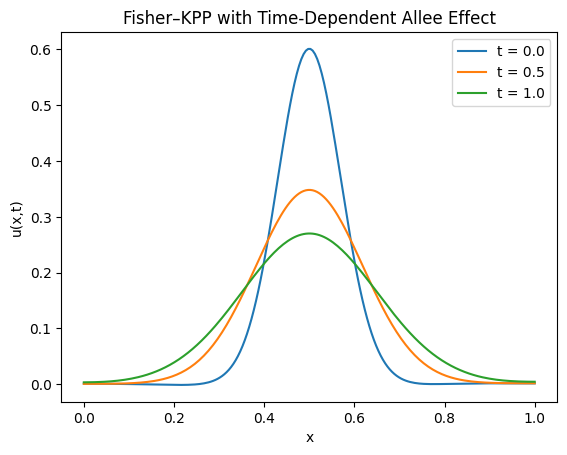

In [ ]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt

# 1. Problem parameters
D = 0.01  # diffusion coefficient
r = 1.0  # intrinsic growth rate
K = 1.0  # carrying capacity
m0 = 0.3  # mean Allee threshold
A = 0.1  # amplitude of oscillation
T = 1.0  # period of oscillation

# 2. Geometry: 1D interval × time
geom = dde.geometry.Interval(0.0, 1.0)
timedomain = dde.geometry.TimeDomain(0.0, 1.0)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


# 3. PDE residual
def pde(x, y):
    # x[:, 0:1] = spatial coordinate; x[:, 1:2] = time
    u = y[:, 0:1]
    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    # time‑dependent Allee threshold
    m_t = m0 + A * tf.sin(2 * np.pi * x[:, 1:2] / T)
    # reaction term with Allee effect
    reaction = r * u * (1 - u / K) * (u - m_t)
    return u_t - D * u_xx - reaction


# 4. Initial condition: Gaussian bump centered at x=0.5
def initial_u(x):
    return 0.6 * np.exp(-(((x[:, 0:1] - 0.5) / 0.1) ** 2))


ic = dde.IC(
    geomtime,
    initial_u,
    lambda _, on_init: on_init,
    component=0,
)


# 5. Neumann boundary condition (zero flux) at x=0 and x=1
def boundary(_, on_boundary):
    return on_boundary


bc = dde.NeumannBC(
    geomtime,
    lambda x: 0.0,
    boundary,
    component=0,
)

# 6. Assemble the data
data = dde.data.TimePDE(
    geomtime,
    pde,
    [ic, bc],
    num_domain=20000,
    num_boundary=2000,
    num_initial=2000,
    num_test=5000,
)

# 7. Neural network
layer_size = [2] + [50] * 4 + [1]  # inputs: (x, t); output: u
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

# 8. Model compilation and training (no analytic solution → no metrics)
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=10000)

# 9. Visualization: u(x, t) at t = 0.0, 0.5, 1.0
xx = np.linspace(0, 1, 200)
for t_val in [0.0, 0.5, 1.0]:
    X = np.vstack((xx, np.full_like(xx, t_val))).T
    u_pred = model.predict(X).flatten()
    plt.plot(xx, u_pred, label=f"t = {t_val:.1f}")

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("Fisher–KPP with Time‑Dependent Allee Effect")
plt.legend()
plt.show()

Compiling model...
Building feed-forward neural network...
'build' took 0.088330 s



I0000 00:00:1744921473.322079      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744921473.322381      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


'compile' took 1.033532 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.45e-03, 8.08e-03, 8.80e-03]    [3.69e-03, 8.08e-03, 8.80e-03]    []  
1000      [2.40e-05, 5.30e-03, 6.34e-05]    [1.82e-05, 5.30e-03, 6.34e-05]    []  
2000      [3.83e-05, 4.74e-03, 4.63e-05]    [3.22e-05, 4.74e-03, 4.63e-05]    []  
3000      [6.53e-05, 3.41e-03, 7.30e-05]    [5.61e-05, 3.41e-03, 7.30e-05]    []  
4000      [2.55e-04, 9.06e-04, 3.15e-05]    [2.27e-04, 9.06e-04, 3.15e-05]    []  
5000      [1.68e-04, 2.52e-04, 4.74e-05]    [1.40e-04, 2.52e-04, 4.74e-05]    []  
6000      [9.29e-05, 8.33e-05, 1.52e-05]    [7.67e-05, 8.33e-05, 1.52e-05]    []  
7000      [6.01e-05, 3.85e-05, 2.25e-05]    [5.23e-05, 3.85e-05, 2.25e-05]    []  
8000      [3.22e-05, 1.45e-05, 4.66e-06]    [2.88e-05, 1.45e-05, 4.66e-06]    []  
9000      [2.12e-05, 8.15e-06, 2.81e-06]    [1.93e-05, 8.15e-06, 2.81e-06]    []  
10000     [1.65e-05, 5.58e-06, 2.5

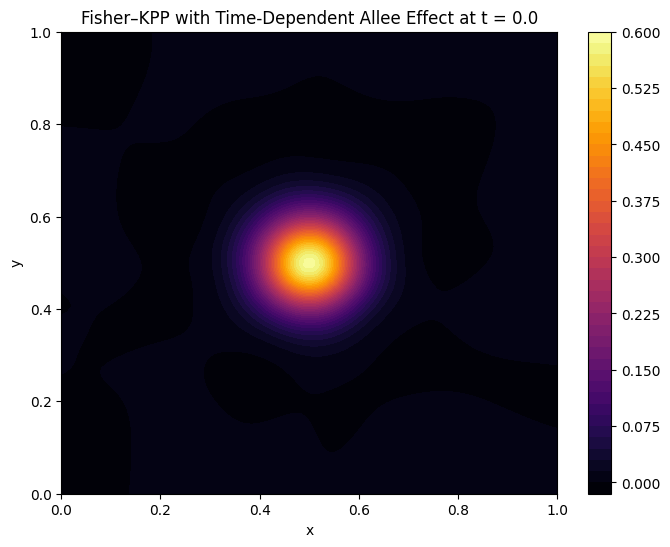

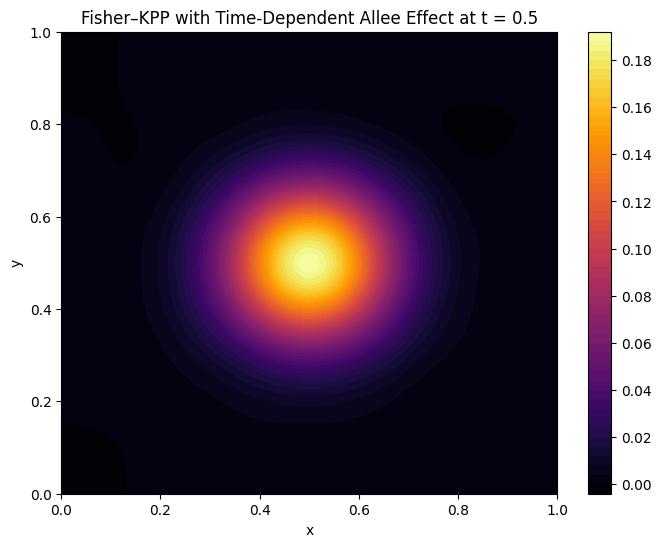

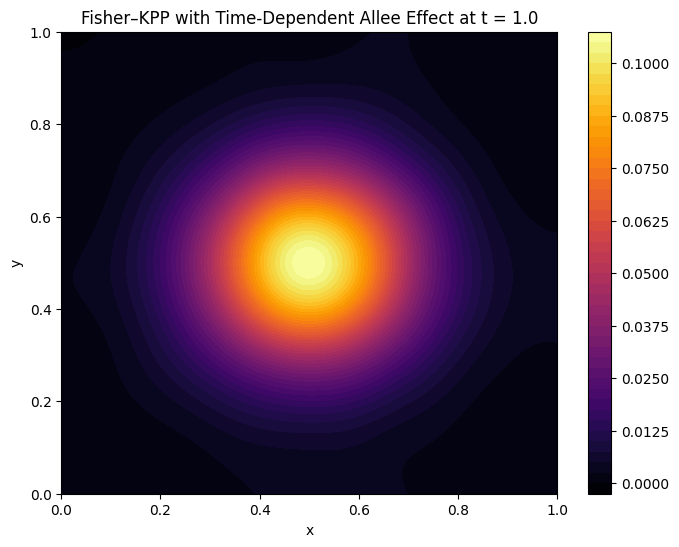

In [ ]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt

# 1. Problem parameters
D = 0.01  # diffusion coefficient
r = 1.0  # intrinsic growth rate
K = 1.0  # carrying capacity
m0 = 0.3  # mean Allee threshold
A = 0.1  # amplitude of oscillation
T = 1.0  # period of oscillation

# 2. Geometry: 2D square region × time
geom = dde.geometry.Rectangle([0.0, 0.0], [1.0, 1.0])
timedomain = dde.geometry.TimeDomain(0.0, 1.0)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


# 3. PDE residual
def pde(x, y):
    # x[:, 0:1] = spatial x; x[:, 1:2] = spatial y; x[:, 2:3] = time
    u = y[:, 0:1]
    u_t = dde.grad.jacobian(y, x, i=0, j=2)
    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0) + dde.grad.hessian(
        y, x, component=0, i=1, j=1
    )
    # time‑dependent Allee threshold
    m_t = m0 + A * tf.sin(2 * np.pi * x[:, 2:3] / T)
    # reaction term with Allee effect
    reaction = r * u * (1 - u / K) * (u - m_t)
    return u_t - D * u_xx - reaction


# 4. Initial condition: Gaussian bump centered at (0.5, 0.5)
def initial_u(x):
    return 0.6 * np.exp(
        -(((x[:, 0:1] - 0.5) / 0.1) ** 2 + ((x[:, 1:2] - 0.5) / 0.1) ** 2)
    )


ic = dde.IC(
    geomtime,
    initial_u,
    lambda _, on_init: on_init,
    component=0,
)


# 5. Neumann boundary condition (zero flux) at x=0, x=1, y=0, and y=1
def boundary(_, on_boundary):
    return on_boundary


bc = dde.NeumannBC(
    geomtime,
    lambda x: 0.0,
    boundary,
    component=0,
)

# 6. Assemble the data
data = dde.data.TimePDE(
    geomtime,
    pde,
    [ic, bc],
    num_domain=20000,
    num_boundary=2000,
    num_initial=2000,
    num_test=5000,
)

# 7. Neural network
layer_size = [3] + [50] * 4 + [1]  # inputs: (x, y, t); output: u
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

# 8. Model compilation and training (no analytic solution → no metrics)
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=10000)

# 9. Visualization: u(x, y, t) at t = 0.0, 0.5, 1.0 (2D projections)
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
xx = xx.flatten()
yy = yy.flatten()

for t_val in [0.0, 0.5, 1.0]:
    X = np.vstack((xx, yy, np.full_like(xx, t_val))).T
    u_pred = model.predict(X).flatten()

    # Reshape for plotting
    u_pred_grid = u_pred.reshape((100, 100))

    plt.figure(figsize=(8, 6))
    plt.contourf(
        np.linspace(0, 1, 100), np.linspace(0, 1, 100), u_pred_grid, 50, cmap="inferno"
    )
    plt.colorbar()
    plt.title(f"Fisher–KPP with Time‑Dependent Allee Effect at t = {t_val:.1f}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

Compiling model...
Building feed-forward neural network...
'build' took 0.089195 s



I0000 00:00:1744921630.385051      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744921630.385325      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


'compile' took 0.883252 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [9.13e-03, 3.96e-02, 1.35e-02]    [8.04e-03, 3.96e-02, 1.35e-02]    []  
1000      [2.32e-03, 5.45e-03, 4.91e-04]    [1.95e-03, 5.45e-03, 4.91e-04]    []  
2000      [2.27e-04, 1.15e-04, 1.56e-05]    [1.62e-04, 1.15e-04, 1.56e-05]    []  
3000      [9.46e-05, 2.65e-05, 1.15e-05]    [7.00e-05, 2.65e-05, 1.15e-05]    []  
4000      [5.06e-05, 1.15e-05, 7.34e-06]    [3.89e-05, 1.15e-05, 7.34e-06]    []  
5000      [3.04e-05, 6.62e-06, 5.39e-06]    [2.41e-05, 6.62e-06, 5.39e-06]    []  
6000      [2.13e-05, 4.64e-06, 4.27e-06]    [1.70e-05, 4.64e-06, 4.27e-06]    []  
7000      [3.02e-05, 9.83e-06, 2.59e-05]    [2.43e-05, 9.83e-06, 2.59e-05]    []  
8000      [1.48e-05, 2.51e-06, 3.15e-06]    [1.17e-05, 2.51e-06, 3.15e-06]    []  
9000      [1.34e-05, 1.87e-06, 2.79e-06]    [1.07e-05, 1.87e-06, 2.79e-06]    []  
10000     [1.25e-05, 1.34e-06, 2.4

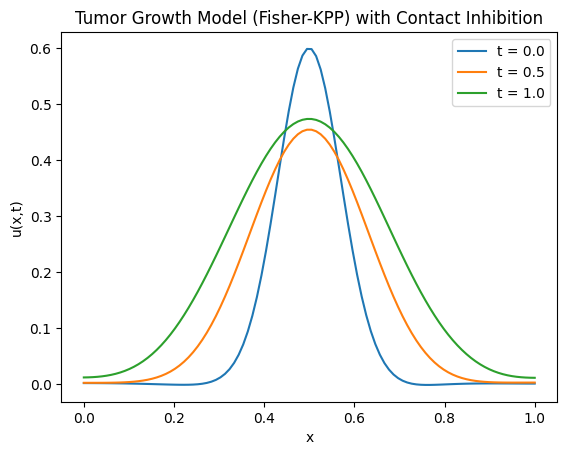

In [ ]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt

# 1. Problem parameters
D = 0.01  # diffusion coefficient
r = 1.0  # intrinsic growth rate
K = 1.0  # carrying capacity
a = 0.05  # contact inhibition constant
T = 1.0  # final time

# 2. Geometry: 1D interval × time
geom = dde.geometry.Interval(0.0, 1.0)
timedomain = dde.geometry.TimeDomain(0.0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


# 3. PDE residual: Fisher-KPP model with proliferation term
def pde(x, y):
    u = y[:, 0:1]
    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    # Tumor growth model with simple proliferation term
    reaction = r * u * (1 - u / K) - a * u**2
    return u_t - D * u_xx - reaction


# 4. Initial condition: Gaussian bump centered at x = 0.5
def initial_u(x):
    return 0.6 * np.exp(-(((x[:, 0:1] - 0.5) / 0.1) ** 2))


ic = dde.IC(
    geomtime,
    initial_u,
    lambda _, on_init: on_init,
    component=0,
)


# 5. Neumann boundary condition (zero flux) at x=0 and x=1
def boundary(_, on_boundary):
    return on_boundary


bc = dde.NeumannBC(
    geomtime,
    lambda x: 0.0,
    boundary,
    component=0,
)

# 6. Assemble the data
data = dde.data.TimePDE(
    geomtime,
    pde,
    [ic, bc],
    num_domain=20000,
    num_boundary=2000,
    num_initial=2000,
    num_test=5000,
)

# 7. Neural network
layer_size = [2] + [50] * 4 + [1]  # inputs: (x, t); output: u
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

# 8. Model compilation and training
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=10000)

# 9. Visualization: u(x, t) at t = 0.0, 0.5, 1.0
xx = np.linspace(0, 1, 100)
for t_val in [0.0, 0.5, 1.0]:
    X = np.vstack((xx, np.full_like(xx, t_val))).T
    u_pred = model.predict(X).flatten()
    plt.plot(xx, u_pred, label=f"t = {t_val:.1f}")

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("Tumor Growth Model (Fisher-KPP) with Contact Inhibition")
plt.legend()
plt.show()

# Multiphysics System

Compiling model...
Building feed-forward neural network...
'build' took 0.090046 s



I0000 00:00:1744922626.448781      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744922626.449117      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


'compile' took 3.081827 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [6.70e-02, 1.96e-02, 4.58e-02, 5.27e-03, 8.70e-02, 3.21e-02, 1.06e-01, 6.16e-02, 9.48e-02]    [6.70e-02, 1.96e-02, 4.58e-02, 5.27e-03, 8.70e-02, 3.21e-02, 1.06e-01, 6.16e-02, 9.48e-02]    []  
1000      [3.62e-04, 1.07e-03, 1.83e-03, 1.16e-04, 1.75e-02, 4.74e-03, 4.02e-05, 2.75e-04, 2.87e-05]    [3.62e-04, 1.07e-03, 1.83e-03, 1.16e-04, 1.75e-02, 4.74e-03, 4.02e-05, 2.75e-04, 2.87e-05]    []  
2000      [4.37e-04, 1.29e-03, 1.40e-05, 8.64e-06, 1.70e-02, 4.31e-03, 6.73e-06, 1.95e-06, 1.77e-06]    [4.37e-04, 1.29e-03, 1.40e-05, 8.64e-06, 1.70e-02, 4.31e-03, 6.73e-06, 1.95e-06, 1.77e-06]    []  
3000      [4.66e-04, 1.40e-03, 9.88e-06, 5.61e-06, 1.69e-02, 4.18e-03, 2.79e-06, 1.20e-06, 1.19e-06]    [4.66e-04, 1.40e-03, 9.88e-06, 

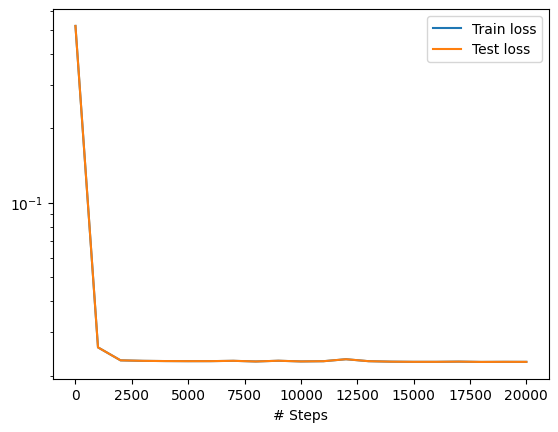

In [ ]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf

# Geometry and time
geom = dde.geometry.Rectangle([-1, -1], [1, 1])
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


# Define PDE system
def pde_system(x, y):
    u = y[:, 0:1]
    phi = y[:, 1:2]
    vx = y[:, 2:3]
    vy = y[:, 3:4]

    # Derivatives
    u_t = dde.grad.jacobian(y, x, i=0, j=2)
    u_xx = dde.grad.hessian(y, x, i=0, j=0)
    u_yy = dde.grad.hessian(y, x, i=0, j=1)

    phi_xx = dde.grad.hessian(y, x, i=1, j=0)
    phi_yy = dde.grad.hessian(y, x, i=1, j=1)

    vx_x = dde.grad.jacobian(y, x, i=2, j=0)
    vx_y = dde.grad.jacobian(y, x, i=2, j=1)
    vy_x = dde.grad.jacobian(y, x, i=3, j=0)
    vy_y = dde.grad.jacobian(y, x, i=3, j=1)

    # Parameters
    Du = 0.01
    alpha = 0.2
    usat = 1.0
    sigma = 1.0
    rho = u

    lam = 1.0
    mu = 0.5

    div_v = vx_x + vy_y
    eps_xx = vx_x
    eps_yy = vy_y
    eps_xy = 0.5 * (vx_y + vy_x)

    # Linear elasticity stress tensor divergence
    fx = (
        lam * tf.gradients(div_v, x)[0][:, 0:1]
        + 2 * mu * tf.gradients(eps_xx, x)[0][:, 0:1]
    )
    fy = (
        lam * tf.gradients(div_v, x)[0][:, 1:2]
        + 2 * mu * tf.gradients(eps_yy, x)[0][:, 1:2]
    )

    # PDEs
    eq_u = u_t - Du * (u_xx + u_yy) + alpha * u * (1 - u / usat)
    eq_phi = -(phi_xx + phi_yy) - rho
    eq_vx = fx
    eq_vy = fy

    return [eq_u, eq_phi, eq_vx, eq_vy]


# Initial and boundary conditions
def func_u(x):
    return np.exp(-5 * (x[:, 0:1] ** 2 + x[:, 1:2] ** 2))


ic = dde.IC(geomtime, func_u, lambda _, on_initial: on_initial, component=0)

bc_u = dde.DirichletBC(
    geomtime, lambda x: 0.0, lambda _, on_boundary: on_boundary, component=0
)
bc_phi = dde.DirichletBC(
    geomtime, lambda x: 0.0, lambda _, on_boundary: on_boundary, component=1
)
bc_vx = dde.DirichletBC(
    geomtime, lambda x: 0.0, lambda _, on_boundary: on_boundary, component=2
)
bc_vy = dde.DirichletBC(
    geomtime, lambda x: 0.0, lambda _, on_boundary: on_boundary, component=3
)

# Define data object
data = dde.data.TimePDE(
    geomtime,
    pde_system,
    [ic, bc_u, bc_phi, bc_vx, bc_vy],
    num_domain=10000,
    num_boundary=1000,
    num_initial=1000,
)

# Network
layer_size = [3] + [50] * 4 + [4]  # 3 inputs (x,y,t), 4 outputs (u,phi,vx,vy)
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

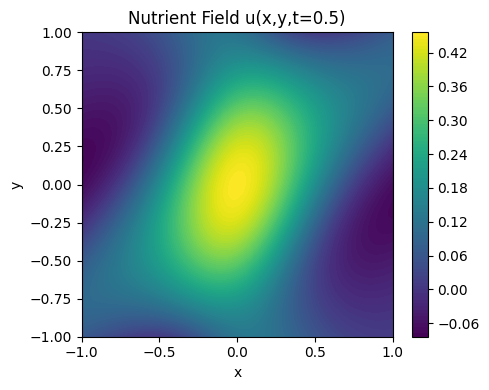

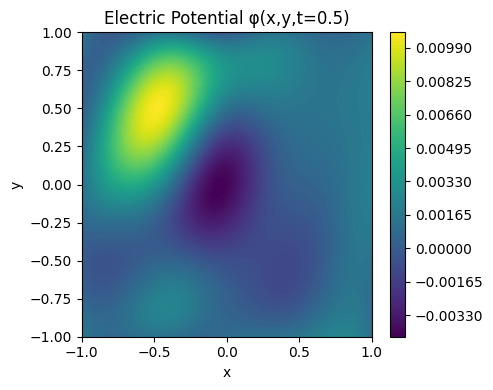

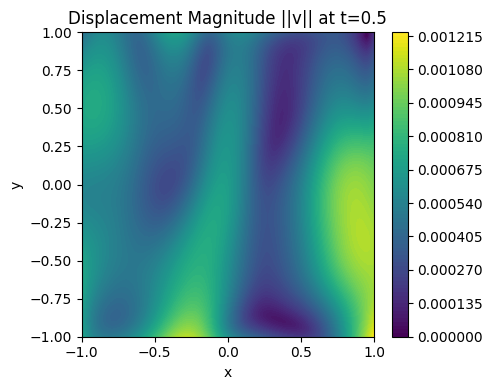

In [ ]:
import matplotlib.pyplot as plt

# Create spatial grid
t_fixed = 0.5
nx = ny = 200
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)
X, Y = np.meshgrid(x, y)
XYT = np.hstack(
    (X.flatten()[:, None], Y.flatten()[:, None], t_fixed * np.ones((nx * ny, 1)))
)

# Predict
pred = model.predict(XYT)
u_pred = pred[:, 0].reshape((nx, ny))
phi_pred = pred[:, 1].reshape((nx, ny))
vx_pred = pred[:, 2].reshape((nx, ny))
vy_pred = pred[:, 3].reshape((nx, ny))


# Plot utility
def plot_field(field, title):
    plt.figure(figsize=(5, 4))
    plt.contourf(X, Y, field, 100, cmap="viridis")
    plt.colorbar()
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    plt.show()


plot_field(u_pred, "Nutrient Field u(x,y,t=0.5)")
plot_field(phi_pred, "Electric Potential φ(x,y,t=0.5)")
plot_field(np.sqrt(vx_pred**2 + vy_pred**2), "Displacement Magnitude ||v|| at t=0.5")

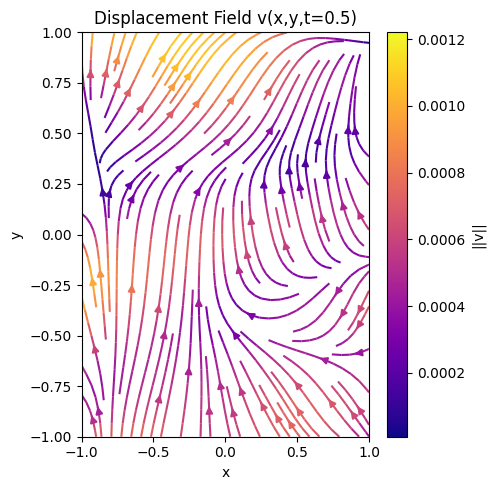

In [ ]:
plt.figure(figsize=(5, 5))
plt.streamplot(
    x,
    y,
    vx_pred.T,
    vy_pred.T,
    color=np.sqrt(vx_pred.T**2 + vy_pred.T**2),
    cmap="plasma",
    density=1,
)
plt.title("Displacement Field v(x,y,t=0.5)")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(label="||v||")
plt.tight_layout()
plt.show()

# Multidynamics System

Compiling model...
Building feed-forward neural network...
'build' took 0.069265 s



I0000 00:00:1744924375.521746      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744924375.522035      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


'compile' took 1.561510 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [6.95e-04, 1.95e-02, 2.86e-02, 9.87e-01, 4.04e-03, 2.20e-02]    [4.78e-04, 1.97e-02, 2.86e-02, 9.87e-01, 4.04e-03, 2.20e-02]    []  
1000      [4.98e-05, 2.04e-04, 2.68e-02, 3.32e-06, 3.23e-04, 1.89e-05]    [1.29e-05, 2.02e-04, 2.68e-02, 3.32e-06, 3.23e-04, 1.89e-05]    []  

Best model at step 1000:
  train loss: 2.74e-02
  test loss: 2.73e-02
  test metric: []

'train' took 12.582182 s



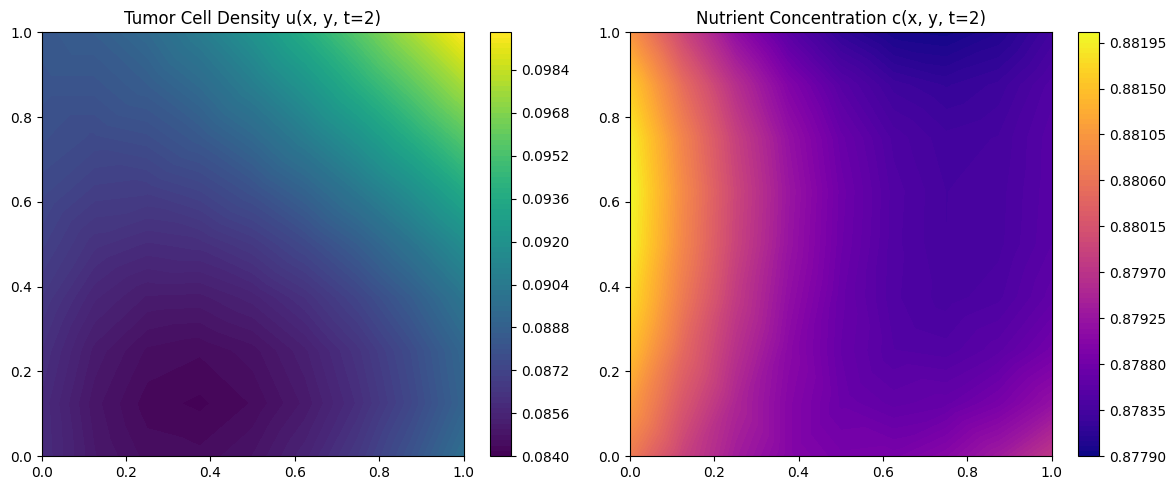

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from deepxde.backend import tf

# Geometry and time domain
L = 1.0
geom = dde.geometry.Rectangle([0, 0], [L, L])
timedomain = dde.geometry.TimeDomain(0, 2)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Parameters
Du = 0.01
eps = 1e-2
kappa = 1.0
mu0 = 0.1
K = 0.2


# PDE system definition
def pde(x, y):
    u, c = y[:, 0:1], y[:, 1:2]

    u_t = dde.grad.jacobian(y, x, i=0, j=2)
    c_t = dde.grad.jacobian(y, x, i=1, j=2)

    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0) + dde.grad.hessian(
        y, x, component=0, i=1, j=1
    )
    c_xx = dde.grad.hessian(y, x, component=1, i=0, j=0) + dde.grad.hessian(
        y, x, component=1, i=1, j=1
    )

    mu = mu0 * c / (K + c)
    return [u_t - Du * u_xx - mu * u * (1 - u), c_t - eps * c_xx + kappa * u * c]


# Initial conditions
def ic_u(x):
    return np.exp(-50 * ((x[:, 0:1] - 0.5) ** 2 + (x[:, 1:2] - 0.5) ** 2))


def ic_c(x):
    return np.ones_like(x[:, 0:1])


# Conditions and boundary definitions
ic1 = dde.IC(geomtime, ic_u, lambda _, on_initial: on_initial, component=0)
ic2 = dde.IC(geomtime, ic_c, lambda _, on_initial: on_initial, component=1)
bc1 = dde.NeumannBC(
    geomtime, lambda x: 0, lambda _, on_boundary: on_boundary, component=0
)
bc2 = dde.NeumannBC(
    geomtime, lambda x: 0, lambda _, on_boundary: on_boundary, component=1
)

# Data definition
data = dde.data.TimePDE(
    geomtime,
    pde,
    [ic1, ic2, bc1, bc2],
    num_domain=5000,
    num_boundary=1000,
    num_initial=500,
    solution=None,
    num_test=1000,
)

# Network architecture
net = dde.maps.FNN([3] + [64] * 3 + [2], "tanh", "Glorot normal")
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(epochs=1000)

# Predict at t=2 to visualize tumor and nutrient distribution
x, y = geomtime.uniform_points(10000, True), None
y_pred = model.predict(x)

# Filter for t = 2
mask = np.isclose(x[:, 2], 2.0, atol=0.01)
x_plot = x[mask]
u_plot = y_pred[mask, 0]
c_plot = y_pred[mask, 1]

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.tricontourf(x_plot[:, 0], x_plot[:, 1], u_plot, 100, cmap="viridis")
plt.colorbar()
plt.title("Tumor Cell Density u(x, y, t=2)")

plt.subplot(1, 2, 2)
plt.tricontourf(x_plot[:, 0], x_plot[:, 1], c_plot, 100, cmap="plasma")
plt.colorbar()
plt.title("Nutrient Concentration c(x, y, t=2)")

plt.tight_layout()
plt.show()